In [17]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation
import random as rnd

rc('animation', html='jshtml')
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [10, 7]

In [2]:
# Constant to obtain box dimensions given the number of particles per row 
crystal_spacing = 1.07

# Boltzmann constant
kB = 1.0 #1.38064852 * 10**-23

# Number of steps between heat capacity output
N_OUTPUT_HEAT_CAP = 1000

In [3]:
# Generate two Gaussian random numbers with standard deviation sigma, mean 0
def gaussianRandomNumbers(sigma):
    w = 2
    while (w >= 1):
        rx1 = 2 * rnd.random() - 1
        rx2 = 2 * rnd.random() - 1
        w = rx1 * rx1 + rx2 * rx2 
    w = math.sqrt(-2 * math.log(w) / w)
    return sigma * rx1 * w, sigma * rx2 * w

# Assigns Gaussian distributed velocities given an energy per particle
def thermalize(vx, vy, sqrtKineticEnergyPerParticle):
    for i in range(0, len(vx)):
        vx[i], vy[i] = gaussianRandomNumbers(sqrtKineticEnergyPerParticle)

# Calculate the shortest periodic distance, unit cell [0,Lx],[0,Ly]
# Returns the difference along x, along y and the distance
# This code assumes all particles are within [0,Lx],[0,Ly]
def pbc_dist(x1, y1, x2, y2, Lx, Ly):
    dx = x1 - x2
    dy = y1 - y2
    while dx < -0.5*Lx:
        dx += Lx
    while dx > 0.5*Lx:
        dx -= Lx
    while dy < -0.5*Ly:
        dy += Ly
    while dy > 0.5*Ly:
        dy -= Ly
    return dx, dy, math.sqrt(dx*dx + dy*dy)


In [ ]:
def thermalize2(vx, vy, kbt):
    for i in range(len(vx)):
        vx[i], vy[i] = rnd.gauss(0, kbt**0.5), rnd.gauss(0, kbt**0.5)

In [4]:
# The pair potential
sigma = 1
epsilon = 1

def pairEnergy(r):
    # TODO
    # Implement the pair energy calculation here!

    return 4*epsilon * ((sigma/r)**12 - (sigma/r)**6) 

# The pair force              
def pairForce(r):
    # TODO
    # Implement the pair force calculation here!
    # this is just dU/dr

    return -4 * epsilon * (6*sigma**6 *(r**6 - 2*sigma**6) / r**13) 

In [5]:
class MDsimulator:

    """
        This class encapsulates the whole MD simulation algorithm
    """

    def __init__(self,
                 n=24,
                 L=6.7,
                 mass=1.0,
                 numPerRow=6,
                 T=0.4,
                 dt=0.01,
                 nsteps=20000,
                 numStepsPerFrame=100,
                 startStepForAveraging=100, 
                 thermalize_with_andersen=-1,
                 ):
        """
            This is the class 'constructor'; if you want to try different simulations with different parameters 
            (e.g. temperature) in the same scrip, allocate another simulator by passing a different value as input
            argument. See the examples at the end of the script.
        """

        # Initialize simulation parameters and box
        self.n = n
        self.mass = 1.0
        self.invmass = 1.0/mass
        self.numPerRow = numPerRow
        self.Lx = L
        self.Ly = L
        self.T = T
        self.kBT = kB*T
        self.dt = dt
        self.nsteps = nsteps
        self.numStepsPerFrame = numStepsPerFrame
        # Initialize positions, velocities and forces
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        self.fx = []
        self.fy = []
        for i in range(n):
            self.x.append(crystal_spacing *
                          ((i % numPerRow) + 0.5*(i / numPerRow)))
            self.y.append(crystal_spacing*0.87*(i/numPerRow))
            self.vx.append(0.0)
            self.vy.append(0.0)
            self.fx.append(0.0)
            self.fy.append(0.0)
        self.thermalize_with_andersen = thermalize_with_andersen
        thermalize(self.vx, self.vy, np.sqrt(self.kBT/self.mass))
        # Initialize containers for energies
        self.sumEpot = 0
        self.sumEpot2 = 0
        self.sumPV = 0
        self.outt = []
        self.ekinList = []
        self.epotList = []
        self.etotList = []
        self.pvList = []
        self.startStepForAveraging = startStepForAveraging
        self.step = 0
        self.Epot = 0
        self.Ekin = 0
        self.PV = 0
        self.Cv = 0
        # Initialize figure for animation
        #self.fig = plt.figure()
        #self.ax = plt.subplot(xlim=(0, self.Lx), ylim=(0, self.Ly))

    def clear_energy_potential(self):
        """
            Clear the temporary variables storing potential and kinetic energy
            Resets forces to zero
        """

        self.Epot = 0
        self.Ekin = 0
        for i in range(0, self.n):
            self.fx[i] = 0
            self.fy[i] = 0

    def update_forces(self):
        """
            Updates forces and potential energy using functions
            pairEnergy and pairForce (which you coded above...)
            Returns the virial: 1/2 sum f*r
        """

        sum_f_times_r = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                dx, dy, r = pbc_dist(
                    self.x[i], self.y[i], self.x[j], self.y[j], self.Lx, self.Ly)
                self.Epot += pairEnergy(r)
                fij = pairForce(r)
                self.fx[i] += fij * dx / r
                self.fy[i] += fij * dy / r
                self.fx[j] -= fij * dx / r
                self.fy[j] -= fij * dy / r
                sum_f_times_r += fij * r

        # Here we divide by 4 instead of 2 because we double-counted the forces
        return -sum_f_times_r / 4

    def propagate(self):
        """
            Performs an Hamiltonian propagation step and
            rescales velocities to match the input temperature 
            (THE LATTER YOU NEED TO IMPLEMENT!)
        """

        for i in range(0, self.n):
            # At the first step we alread have the "full step" velocity
            if self.step > 0:
                # Update the velocities with a half step
                self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
                self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt

            # TODO
            # When temperature coupling, modify the velocity of one or more particles here
            if self.thermalize_with_andersen > 0 and self.step%self.thermalize_with_andersen == 0:
                self.vx[i], self.vy[i] = gaussianRandomNumbers(np.sqrt(self.kBT/self.mass))

            # Add the kinetic energy of particle i to the total
            self.Ekin += 0.5*self.mass * \
                (self.vx[i]*self.vx[i] + self.vy[i]*self.vy[i])
            # Update the velocities with a half step
            self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
            self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt
            # Update the coordinates
            self.x[i] += self.vx[i] * self.dt
            self.y[i] += self.vy[i] * self.dt
            # Apply p.c.b. and put particles back in the unit cell
            self.x[i] = self.x[i] % self.Lx
            self.y[i] = self.y[i] % self.Ly

    def md_step(self):
        """
            Performs a full MD step
            (computes forces, updates positions/velocities)
        """

        # This function performs one MD integration step
        self.clear_energy_potential()
        virial = self.update_forces()
        self.propagate()
        self.PV = 2 * (self.Ekin - virial)
        # Start averaging only after some initial spin-up time
        if self.step > self.startStepForAveraging:
            self.sumEpot += self.Epot
            self.sumEpot2 += self.Epot * self.Epot
            self.sumPV += self.PV
        self.step += 1

        #if self.thermalize_with_andersen > 0 and self.step%self.thermalize_with_andersen == 0:
        #    #thermalize2(self.vx, self.vy, self.kBT)
        #    thermalize(self.vx, self.vy, np.sqrt(self.kBT/self.mass))

    def integrate_some_steps(self, framenr=None):
        """
            Performs MD steps in a prescribed time window
            Stores energies and heat capacity
        """

        for j in range(self.numStepsPerFrame):
            self.md_step()
        t = self.step*self.dt
        self.outt.append(t)
        self.ekinList.append(self.Ekin)
        self.epotList.append(self.Epot)
        self.etotList.append(self.Epot + self.Ekin)
        self.pvList.append(self.PV)
        if self.step >= self.startStepForAveraging and self.step % N_OUTPUT_HEAT_CAP == 0:
            EpotAv = self.sumEpot/(self.step + 1 - self.startStepForAveraging)
            Epot2Av = self.sumEpot2 / \
                (self.step + 1 - self.startStepForAveraging)
            self.Cv = (Epot2Av - EpotAv * EpotAv) / (self.kBT * self.T)
            pvAv = self.sumPV/(self.step + 1 - self.startStepForAveraging)
            print('time', t, '<Cv> =', self.Cv, "<P>V =", pvAv)

    def snapshot(self, ax, framenr=None):
        """
            This is an 'auxillary' function needed by animation.FuncAnimation
            in order to show the animation of the 2D Lennard-Jones system
        """

        self.integrate_some_steps(framenr)
        return ax.scatter(self.x, self.y, s=1500, marker='o', c="r"),

    def simulate(self):
        """
            Performs the whole MD simulation
            If the total number of steps is not divisible by the frame size, then
            the simulation will run for nsteps-(nsteps%numStepsPerFrame) steps
        """

        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for " +
              str(nn*self.numStepsPerFrame)+" steps ...")
        for i in range(nn):
            if self.step >= self.startStepForAveraging and self.step % N_OUTPUT_HEAT_CAP == 0:
                print(i/nn)
            self.integrate_some_steps()

    def simulate_animate(self):
        """
            Performs the whole MD simulation, while producing and showing the
            animation of the molecular system
            CAREFUL! This will slow down the script execution considerably
        """
        fig = plt.figure()
        ax = plt.subplot(xlim=(0, self.Lx), ylim=(0, self.Ly))

        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for " +
              str(nn*self.numStepsPerFrame)+" steps ...")
        anim = animation.FuncAnimation(fig, lambda x: self.snapshot(ax, x),
                                       frames=nn, interval=50, blit=True, repeat=True)
        plt.show()  # show the animation
        # You may want to (un)comment the following 'waitforbuttonpress', depending on your environment
        # plt.waitforbuttonpress(timeout=20)

        return anim

    def plot_energy(self):
        """
            Plots kinetic, potential and total energy over time
        """

        plt.figure()
        plt.xlabel('time')
        plt.ylabel('energy')
        plt.plot(self.outt, self.ekinList, self.outt, self.epotList,
                 self.outt, self.etotList, self.pvList)
        plt.legend(('Ekin', 'Epot', 'Etot', 'PV'))
        plt.show()


In [ ]:
### a)

# Calling one simulator, animating and plotting
#simulator = MDsimulator()
#anim = simulator.simulate_animate()
#simulator.plot_energy()

# Study the quality of the integration by monitoring the drift in the total energy for several different time steps just before things go wrong.

dt_list = np.logspace(-3,0,40)
std_list = []
#cv_values = []

cnt = 0
for dt in dt_list:
    print(f"loop: {cnt/len(dt_list)}")
    cnt += 1
    simulator = MDsimulator(dt=dt, nsteps=1000, T=1)
    simulator.simulate()
    #cv_values.append(simulator.Cv)
    std_list.append(abs(simulator.etotList[-1] - simulator.etotList[0]))
# TODO
# Plotting and analyzing results ...

loop: 0.0
T=1, integrating for 1000 steps ...
time 1.0 <Cv> = 30.55191536145776 <P>V = 18.629533367330033
loop: 0.025
T=1, integrating for 1000 steps ...
time 1.1937766417144369 <Cv> = 39.23919362653032 <P>V = 60.41005895378878
loop: 0.05
T=1, integrating for 1000 steps ...
time 1.4251026703029976 <Cv> = 28.36821914902589 <P>V = 9.703757437334998
loop: 0.075
T=1, integrating for 1000 steps ...
time 1.7012542798525891 <Cv> = 26.49002252404739 <P>V = 53.587495506835104
loop: 0.1
T=1, integrating for 1000 steps ...
time 2.030917620904735 <Cv> = 14.274773952198075 <P>V = 5.9146893456273055
loop: 0.125
T=1, integrating for 1000 steps ...
time 2.424462017082328 <Cv> = 13.336016117696317 <P>V = 7.121055713516948
loop: 0.15
T=1, integrating for 1000 steps ...
time 2.8942661247167516 <Cv> = 9.35828956006003 <P>V = 29.38065660463639
loop: 0.175
T=1, integrating for 1000 steps ...
time 3.455107294592218 <Cv> = 8.4932808608512 <P>V = 24.808057497081055
loop: 0.2
T=1, integrating for 1000 steps ...

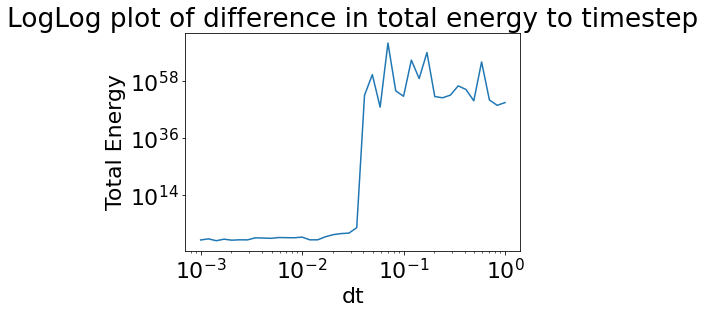

Breaks at around dt = 0.041


In [ ]:
plt.figure()
plt.title('LogLog plot of difference in total energy to timestep')
plt.xlabel('dt')
plt.ylabel('Total Energy')
plt.loglog(dt_list, std_list)
plt.show()

for i in range(len(std_list)):
    if std_list[i] > 100:
        print(f"Breaks at around dt = {dt_list[i]:.3f}")
        break

In [ ]:
### b)

sim1 = MDsimulator(T=1)
sim2 = MDsimulator(T=0.2)

sim1.simulate()
sim2.simulate()

T=1, integrating for 20000 steps ...
time 10.0 <Cv> = 6.195353573241846 <P>V = 14.075856793620758
0.05
time 20.0 <Cv> = 4.720587375057221 <P>V = 14.445071811021467
0.1
time 30.0 <Cv> = 5.031090206198996 <P>V = 10.44564495097244
0.15
time 40.0 <Cv> = 4.504627894682471 <P>V = 9.614437606358948
0.2
time 50.0 <Cv> = 4.158684266273212 <P>V = 10.61100862639754
0.25
time 60.0 <Cv> = 3.8383419864321695 <P>V = 11.588567880727146
0.3
time 70.0 <Cv> = 3.6729161042489977 <P>V = 11.394482785501289
0.35
time 80.0 <Cv> = 3.519425949930792 <P>V = 11.584125007433283
0.4
time 90.0 <Cv> = 3.6209430560043074 <P>V = 12.1430667388846
0.45
time 100.0 <Cv> = 3.6477761249741434 <P>V = 11.888212295915528
0.5
time 110.0 <Cv> = 3.5942146275513096 <P>V = 12.00864029992137
0.55
time 120.0 <Cv> = 3.536969289497165 <P>V = 12.026361478491955
0.6
time 130.0 <Cv> = 3.4573262807450647 <P>V = 12.3070588083566
0.65
time 140.0 <Cv> = 3.5512306471516695 <P>V = 12.248165956781449
0.7
time 150.0 <Cv> = 3.440929678093653 <P>V =

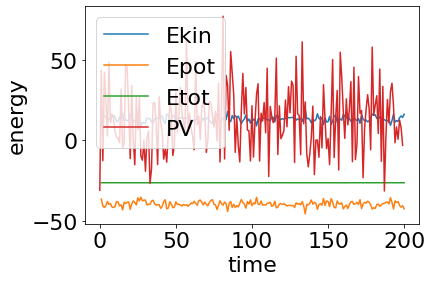

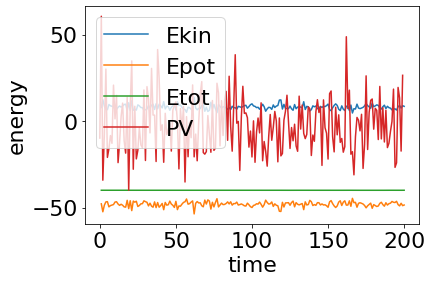

In [ ]:
sim1.plot_energy()
sim2.plot_energy()

[]

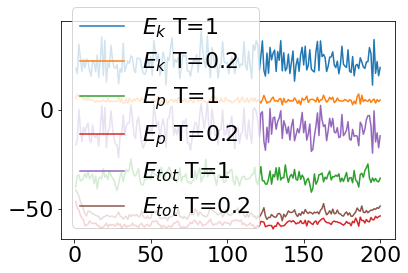

In [ ]:
plt.figure()
plt.plot(sim1.outt, sim1.ekinList, label="$E_k$ T=1")
plt.plot(sim2.outt, sim2.ekinList, label="$E_k$ T=0.2")

plt.plot(sim1.outt, sim1.epotList, label="$E_p$ T=1")
plt.plot(sim2.outt, sim2.epotList, label="$E_p$ T=0.2")

plt.plot(sim1.outt, sim1.etotList, label="$E_{tot}$ T=1")
plt.plot(sim2.outt, sim2.etotList, label="$E_{tot}$ T=0.2")
plt.legend()
plt.plot()

In [ ]:
### c)

sim1 = MDsimulator(T=1, thermalize_with_andersen=100)
sim2 = MDsimulator(T=0.2, thermalize_with_andersen=100)

sim1.simulate()
sim2.simulate()


T=1, integrating for 20000 steps ...
time 10.0 <Cv> = 6.851670334805476 <P>V = 49.609601691438904
0.05
time 20.0 <Cv> = 7.027374813070082 <P>V = 50.86343629530199
0.1
time 30.0 <Cv> = 7.1476305241681075 <P>V = 47.47796063010871
0.15
time 40.0 <Cv> = 7.410030172134611 <P>V = 50.51671774503202
0.2
time 50.0 <Cv> = 7.318188440042604 <P>V = 50.25168573023885
0.25
time 60.0 <Cv> = 7.075210732347614 <P>V = 51.19127210806913
0.3
time 70.0 <Cv> = 7.151098854002157 <P>V = 53.06290487401201
0.35
time 80.0 <Cv> = 6.934633346523469 <P>V = 52.45471326703146
0.4
time 90.0 <Cv> = 7.006647553024322 <P>V = 54.31804435673474
0.45
time 100.0 <Cv> = 6.902997682222576 <P>V = 54.06214522755701
0.5
time 110.0 <Cv> = 6.972755286057691 <P>V = 53.839804077395335
0.55
time 120.0 <Cv> = 7.03709097885303 <P>V = 54.34935338753628
0.6
time 130.0 <Cv> = 6.983963825916817 <P>V = 54.33795708197755
0.65
time 140.0 <Cv> = 6.990366458899871 <P>V = 54.90532589299517
0.7
time 150.0 <Cv> = 6.858089448602641 <P>V = 54.8443865

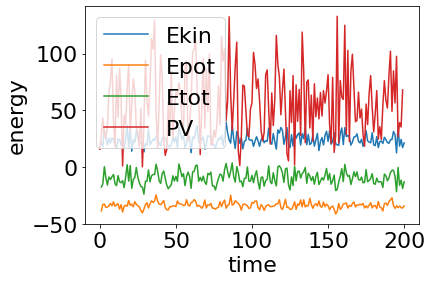

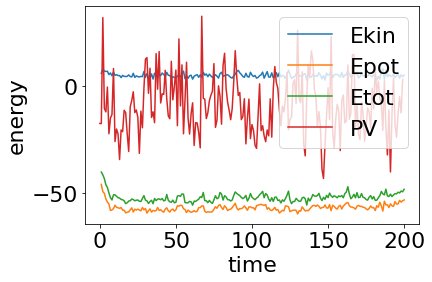

In [ ]:
sim1.plot_energy()
sim2.plot_energy()

[]

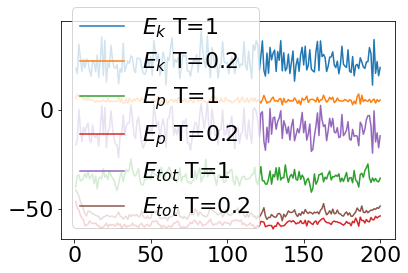

In [ ]:
plt.figure()
plt.plot(sim1.outt, sim1.ekinList, label="$E_k$ T=1")
plt.plot(sim2.outt, sim2.ekinList, label="$E_k$ T=0.2")

plt.plot(sim1.outt, sim1.epotList, label="$E_p$ T=1")
plt.plot(sim2.outt, sim2.epotList, label="$E_p$ T=0.2")

plt.plot(sim1.outt, sim1.etotList, label="$E_{tot}$ T=1")
plt.plot(sim2.outt, sim2.etotList, label="$E_{tot}$ T=0.2")
plt.legend()
plt.plot()

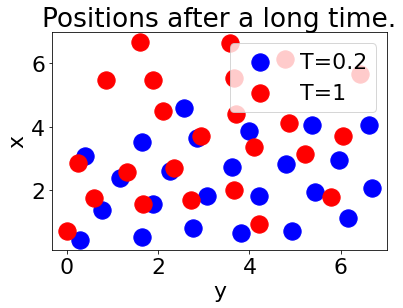

In [ ]:
plt.figure()
plt.title('Positions after a long time.')
plt.xlabel('y')
plt.ylabel('x')
plt.scatter(sim2.x, sim2.y, s=300, marker='o', c="b", label="T=0.2")
plt.scatter(sim1.x, sim1.y, s=300, marker='o', c="r", label="T=1")
plt.legend()
plt.show()

In [13]:
## d)

""" Heat capacity = cv for T in [0.2:1]
    Wrong equation for Cv?? Multiply by T^-1"""
temperature_values = np.linspace(0.2,1,10)
cv_values = []
ave_energy_values = []
for TT in temperature_values :
    print(f'Temp: {TT}')
    simulator = MDsimulator(T=TT, thermalize_with_andersen=50, startStepForAveraging=1000, dt=0.02)
    simulator.simulate()
    cv_values.append(simulator.Cv)
    ave_energy_values.append(simulator.sumEpot/(simulator.step + 1 - simulator.startStepForAveraging))

# temperature_values, cv_values, ave_energy_values

Temp: 0.2
T=0.2, integrating for 20000 steps ...
time 20.0 <Cv> = 0.0 <P>V = 0.0
0.05
time 40.0 <Cv> = 188.68680588232107 <P>V = -9.288407129453434
0.1
time 60.0 <Cv> = 114.33571453810598 <P>V = -9.267585244098475
0.15
time 80.0 <Cv> = 90.37552810320902 <P>V = -11.129159348026658
0.2
time 100.0 <Cv> = 75.45826842350606 <P>V = -10.835168322541742
0.25
time 120.0 <Cv> = 73.94507205948456 <P>V = -6.202383441207714
0.3
time 140.0 <Cv> = 67.36709715776213 <P>V = -2.649225671118702
0.35
time 160.0 <Cv> = 63.606068934655 <P>V = -1.8583814606226845
0.4
time 180.0 <Cv> = 63.35728252595344 <P>V = -1.3832587056140315
0.45
time 200.0 <Cv> = 64.0175171540818 <P>V = -2.460980043712516
0.5
time 220.0 <Cv> = 61.834925716345865 <P>V = -3.271425988045918
0.55
time 240.0 <Cv> = 60.80566663376884 <P>V = -4.139048395064942
0.6
time 260.0 <Cv> = 58.29288513397158 <P>V = -4.001095563497139
0.65
time 280.0 <Cv> = 57.308308858000586 <P>V = -3.4815542859342106
0.7
time 300.0 <Cv> = 59.24733432750598 <P>V = -2.3

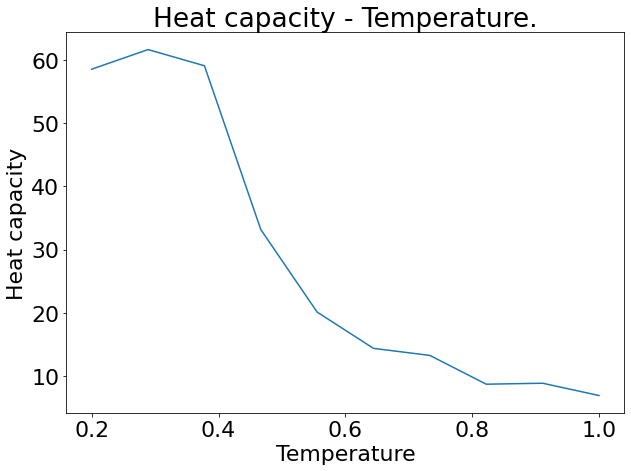

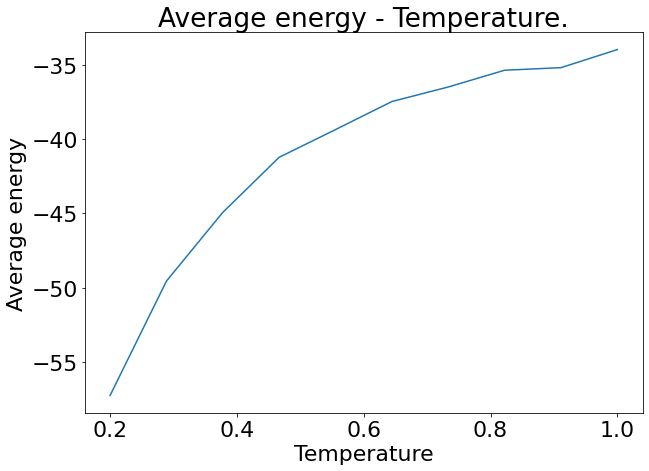

In [18]:
plt.figure()
plt.title('Heat capacity - Temperature.')
plt.xlabel('Temperature')
plt.ylabel('Heat capacity')
plt.plot(temperature_values, cv_values)
plt.show()

plt.figure()
plt.title('Average energy - Temperature.')
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.plot(temperature_values, ave_energy_values)
plt.show()

In [19]:
# e)
L = 6.7 * 2.
temperature_values = np.linspace(0.2,1,10)
pressure_values = []
for TT in temperature_values :
    simulator = MDsimulator(T=TT, L=L, nsteps=10000, thermalize_with_andersen=50, startStepForAveraging=1000, dt=0.02)
    simulator.simulate()
    pressure_values.append(np.mean(simulator.pvList))


T=0.2, integrating for 20000 steps ...
time 20.0 <Cv> = 0.0 <P>V = 0.0
0.05
time 40.0 <Cv> = 165.6457733592333 <P>V = 6.752229267344372
0.1
time 60.0 <Cv> = 94.64246762756828 <P>V = 6.183157810703847
0.15
time 80.0 <Cv> = 72.95257177836446 <P>V = 5.43464338835787
0.2
time 100.0 <Cv> = 62.448217148698845 <P>V = 4.943497609529128
0.25
time 120.0 <Cv> = 63.96567127238767 <P>V = 4.669656305343114
0.3
time 140.0 <Cv> = 59.514599111071206 <P>V = 4.47853911245834
0.35
time 160.0 <Cv> = 54.845244876310055 <P>V = 4.561654525659899
0.4
time 180.0 <Cv> = 52.06919612659248 <P>V = 4.56213855498689
0.45
time 200.0 <Cv> = 53.05698307057582 <P>V = 4.634441030532195
0.5
time 220.0 <Cv> = 50.48895552346266 <P>V = 4.668645355000931
0.55
time 240.0 <Cv> = 48.55287241292671 <P>V = 4.676316747812423
0.6
time 260.0 <Cv> = 46.9769980577098 <P>V = 4.738264426275622
0.65
time 280.0 <Cv> = 48.53007214784383 <P>V = 4.9027377394504175
0.7
time 300.0 <Cv> = 46.87703558655584 <P>V = 4.861118407364533
0.75
time 320.0

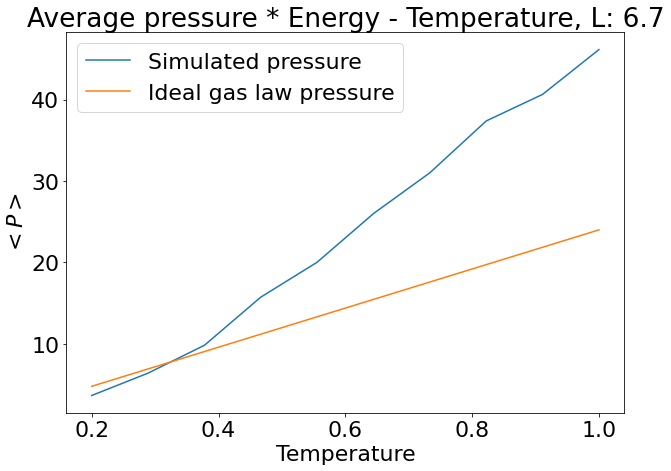

In [29]:
plt.figure()
plt.title(f'Average pressure * Energy - Temperature, L: {L}')
plt.xlabel('Temperature')
plt.ylabel('$<P>$')
plt.plot(temperature_values, pressure_values, label="Simulated pressure")
plt.plot(temperature_values, list(map(lambda t: 24*t, temperature_values)), label="Ideal gas law pressure")
plt.legend()
plt.show()

In [32]:
L = 6.7
temperature_values2 = np.linspace(0.2,1,20)
pressure_values2 = []
for TT in temperature_values2 :
    simulator = MDsimulator(T=TT, L=L, nsteps=5000 ,thermalize_with_andersen=50, startStepForAveraging=100, dt=0.02)
    simulator.simulate()
    pressure_values2.append(np.mean(simulator.pvList))

T=0.2, integrating for 5000 steps ...
time 20.0 <Cv> = 203.63857482634555 <P>V = -10.9447456709931
0.2
time 40.0 <Cv> = 107.58917804797646 <P>V = -11.791153576132023
0.4
time 60.0 <Cv> = 76.77944716600676 <P>V = -11.815949599049146
0.6
time 80.0 <Cv> = 61.848731955888056 <P>V = -11.790841295428832
0.8
time 100.0 <Cv> = 78.1722450292932 <P>V = -9.380651406046708
T=0.24210526315789474, integrating for 5000 steps ...
time 20.0 <Cv> = 158.03604231573368 <P>V = -4.934169587381393
0.2
time 40.0 <Cv> = 101.51512635105627 <P>V = -7.6596241215476955
0.4
time 60.0 <Cv> = 78.93116161038776 <P>V = -6.744752129672936
0.6
time 80.0 <Cv> = 98.04136590937271 <P>V = 0.1790221329493798
0.8
time 100.0 <Cv> = 91.75320227401981 <P>V = 4.366427298356993
T=0.28421052631578947, integrating for 5000 steps ...
time 20.0 <Cv> = 193.2681031422587 <P>V = -3.7854196978529533
0.2
time 40.0 <Cv> = 104.40121120703087 <P>V = -3.281145343642056
0.4
time 60.0 <Cv> = 84.88993103497967 <P>V = -2.952059777759385
0.6
time 80

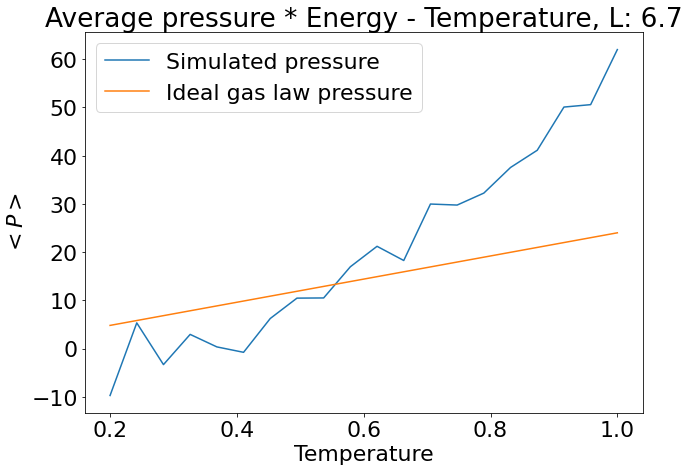

In [33]:
plt.figure()
plt.title(f'Average pressure * Energy - Temperature, L: {L}')
plt.xlabel('Temperature')
plt.ylabel('$<P>$')
plt.plot(temperature_values2, pressure_values2, label="Simulated pressure")
plt.plot(temperature_values2, list(map(lambda t: 24*t, temperature_values2)), label="Ideal gas law pressure")
plt.legend()
plt.show()